In [1]:
# DIR = "/content/drive/MyDrive/College (Master)/Semester 3/COMP90090 - Natural Language Processing for Health/Assignment/Assignment 3/"
DIR = "../output"

In [2]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt

from itertools import groupby

import warnings
warnings.filterwarnings("ignore")

In [3]:
DISORDERS = ['ppd', 'mdd', 'ocd', 'ptsd', 'adhd',
             'bipolar', 'anxiety', 'depression']
LABEL = DISORDERS + ['neg']

In [4]:
from empath import Empath

lexicon = Empath()

# Feature Extraction

In [5]:
LABEL[-1:]

['neg']

In [6]:
import os

# Store data about user_id, tweet_id, date, sentiment, disorder, covid

for l in LABEL[-1:]:
    print(f"Working on label {l}")
    reader = pd.read_csv(f"{DIR}/{l}/tweets_{l}.csv", dtype=str, chunksize=500000, on_bad_lines='warn', lineterminator=";")

    i = 0
    for r in reader:
        i += 1
        sentiments = []
        for text in r['text'].values:
            try:
                polarity = lexicon.analyze(text, categories=["positive_emotion", "negative_emotion"], normalize=True)
                if polarity is None:
                    polarity = {'positive_emotion':0, 'negative_emotion':0}
                    
                sentiments.append(polarity)
            except AttributeError:
                sentiments.append({'positive_emotion':0, 'negative_emotion':0})

        sent_df = pd.DataFrame(sentiments)
        df = r[['tweet_id', 'user_id', 'disorder_flag', 'timestamp_tweet']]
        df.loc[:,'positive_emotion'] = sent_df['positive_emotion'].values
        df.loc[:,'negative_emotion'] = sent_df['negative_emotion'].values
        print(f"Chunk number {i}")

        if not os.path.exists(f"{DIR}/{l}/moods_{l}.csv"):
            df.to_csv(f"{DIR}/{l}/moods_{l}.csv")
        else:
            df.to_csv(f"{DIR}/{l}/moods_{l}.csv", mode='a', header=False)


    print(" FINISHED")

Working on label neg
Chunk number 1
Chunk number 2
Chunk number 3
Chunk number 4
Chunk number 5
Chunk number 6
Chunk number 7
Chunk number 8
Chunk number 9
Chunk number 10
Chunk number 11
Chunk number 12
Chunk number 13
Chunk number 14
Chunk number 15
Chunk number 16
Chunk number 17
Chunk number 18
Chunk number 19
Chunk number 20
Chunk number 21
Chunk number 22
Chunk number 23
Chunk number 24
Chunk number 25
Chunk number 26
Chunk number 27
Chunk number 28
Chunk number 29
Chunk number 30
Chunk number 31
Chunk number 32
Chunk number 33
Chunk number 34
Chunk number 35
Chunk number 36
Chunk number 37
Chunk number 38
Chunk number 39
Chunk number 40
Chunk number 41
Chunk number 42
Chunk number 43
Chunk number 44
Chunk number 45
Chunk number 46
Chunk number 47
Chunk number 48
Chunk number 49
Chunk number 50
Chunk number 51
Chunk number 52
Chunk number 53
Chunk number 54
Chunk number 55
Chunk number 56
Chunk number 57
Chunk number 58
Chunk number 59
Chunk number 60
Chunk number 61
Chunk number

# Detailed Feature Extraction

In [7]:
features = ['max_msd', 'mean_msd',
            'positive_ratio', 'negative_ratio',
            'positive_combo', 'negative_combo']

In [8]:
dfs = []

In [9]:
def extract_feature(compounds, temp):
    # Moving windows
    rolling_std = compounds.rolling(window=2).std()
    temp[0].append(np.max(rolling_std))
    temp[1].append(np.mean(rolling_std))

    goods = (compounds > 0)
    bads = (compounds < 0)
    # moods ratio
    positives = np.count_nonzero(goods)
    negatives = np.count_nonzero(bads)
    temp[2].append(positives / len(compounds))
    temp[3].append(negatives / len(compounds))

    # moods combo
    consecutive_positives = np.array([sum(1 for _ in group) for key, group in groupby(goods) if key == 1])
    consecutive_negatives = np.array([sum(1 for _ in group) for key, group in groupby(bads) if key == 1])
    temp[4].append((consecutive_positives >= 6).sum())
    temp[5].append((consecutive_negatives >= 6).sum())

    return temp

In [10]:
for l_i, l in enumerate(LABEL[-1:]):
    print(f"Working on label {l}")
    reader = pd.read_csv(f"{DIR}/{l}/moods_{l}.csv", dtype=dict(zip(['positive_emotion', 'negative_emotion'], [float for i in range(len(['positive_emotion', 'negative_emotion']))])), chunksize=500000, on_bad_lines='warn', index_col=0, parse_dates=['timestamp_tweet'])

    if l == 'neg':
        temp_before_covid = [[] for i in range(len(features))]
        temp_after_covid = [[] for i in range(len(features))]

    temp = [[] for i in range(len(features))]
    append_df = None
    i = 0
    total_user = 0
    for r in reader:
        i += 1
        # Moving chunks
        if i > 1: r = pd.concat([append_df, r], ignore_index=True, axis=0)

        # Get dataframe without last user
        users = r['user_id'].unique()
        last_user = users[-1]
        mask = (r.user_id == last_user)
        append_df = r[mask]
        r = r[~mask]
        users = users[:-1]

        # Convert timestamp
        r['date'] = r['timestamp_tweet'].dt.date
        r['hour'] = r['timestamp_tweet'].dt.hour
        r.drop(['timestamp_tweet'], axis=1, inplace=True)

        # Group by hours
        # result_hour = r[['tweet_id', 'hour']].groupby(['hour']).count()
        # if len(result_hour) == 0: continue
        # hourly_rate[l_i,:] = result_hour.values.ravel()
        total_user += len(users)

        # Group by date
        result_date = r.groupby(['user_id', 'date']).agg(dict(zip(['positive_emotion', 'negative_emotion'],['mean' for i in range(len(['positive_emotion', 'negative_emotion']))])))
        # df_before_covid = result_date[result_date.index.get_level_values('date') < covid_date]
        # df_after_covid = result_date[result_date.index.get_level_values('date') >= covid_date]

        # Extract features
        for u in users:
            compounds = result_date.loc[u, 'positive_emotion'] - result_date.loc[u, 'negative_emotion']
            temp = extract_feature(compounds, temp)

            # Extract data for covid analysis
            # if l == 'neg' and u in df_before_covid.index.get_level_values('user_id') and u in df_after_covid.index.get_level_values('user_id'):
            #     temp_before_covid = extract_feature(df_before_covid.loc[u, 'compound'], temp_before_covid)
            #     temp_after_covid = extract_feature(df_after_covid.loc[u, 'compound'], temp_after_covid)

        print("Chunk number", i, total_user)

    # hourly_rate[l_i,:] /= total_user
    df = pd.DataFrame([list(i) for i in zip(*temp)], columns=features)
    df.to_csv(f"{DIR}/moods_analysis_{l}.csv")

    print("FINISHED")

Working on label neg
Chunk number 1 87
Chunk number 2 146
Chunk number 3 220
Chunk number 4 257
Chunk number 5 288
Chunk number 6 304
Chunk number 7 364
Chunk number 8 426
Chunk number 9 513
Chunk number 10 574
Chunk number 11 666
Chunk number 12 724
Chunk number 13 817
Chunk number 14 876
Chunk number 15 938
Chunk number 16 1007
Chunk number 17 1060
Chunk number 18 1110
Chunk number 19 1173
Chunk number 20 1215
Chunk number 21 1260
Chunk number 22 1332
Chunk number 23 1366
Chunk number 24 1425
Chunk number 25 1505
Chunk number 26 1551
Chunk number 27 1598
Chunk number 28 1658
Chunk number 29 1714
Chunk number 30 1752
Chunk number 31 1765
Chunk number 32 1812
Chunk number 33 1868
Chunk number 34 1922
Chunk number 35 1977
Chunk number 36 2026
Chunk number 37 2079
Chunk number 38 2136
Chunk number 39 2222
Chunk number 40 2248
Chunk number 41 2264
Chunk number 42 2303
Chunk number 43 2303
Chunk number 44 2323
Chunk number 45 2374
Chunk number 46 2430
Chunk number 47 2483
Chunk number 48 2

# Analysis

In [12]:
dfs = []

for l in LABEL:
    ea_disorder = []
    df = pd.read_csv(f"../output/moods_analysis_{l}.csv", index_col=0)
    ea_disorder.append(df)
    feat = pd.concat(ea_disorder, axis=1)
    dfs.append(feat)

## Window-based feature, moods ratio, moods combo

In [17]:
summ = pd.DataFrame(index=features, columns=DISORDERS)

for col in features:
    for i in range(len(DISORDERS)):
        t_statistic1, p_value1 = stats.ttest_ind(dfs[i][col].values, dfs[-1][col].values)
        value = "***" if p_value1 < 0.001 else "**" if p_value1 < 0.01 else "*" if p_value1 <0.05 else "." if p_value1 < 0.1 else "-"
        color = "" if value == "-" else "\cellcolor{red!25}" if round(t_statistic1,1) < 0 else "\cellcolor{green!25}"
        summ.at[col, DISORDERS[i]] = color + value

summ

,ppd,mdd,ocd,ptsd,adhd,bipolar,anxiety,depression
max_msd,-,\cellcolor{green!25}***,-,-,\cellcolor{green!25}***,\cellcolor{green!25}***,\cellcolor{green!25}***,\cellcolor{green!25}***
mean_msd,\cellcolor{green!25}***,\cellcolor{green!25}***,\cellcolor{green!25}***,\cellcolor{green!25}***,\cellcolor{green!25}***,\cellcolor{green!25}***,\cellcolor{green!25}***,\cellcolor{green!25}***
positive_ratio,\cellcolor{green!25}***,\cellcolor{green!25}***,\cellcolor{green!25}***,\cellcolor{green!25}***,\cellcolor{green!25}***,\cellcolor{green!25}***,\cellcolor{green!25}***,\cellcolor{green!25}***
negative_ratio,\cellcolor{green!25}***,\cellcolor{green!25}***,\cellcolor{green!25}***,\cellcolor{green!25}***,\cellcolor{green!25}***,\cellcolor{green!25}***,\cellcolor{green!25}***,\cellcolor{green!25}***
positive_combo,-,-,-,-,\cellcolor{red!25}**,\cellcolor{green!25}***,\cellcolor{green!25}***,\cellcolor{green!25}*
negative_combo,-,-,-,\cellcolor{green!25}*,\cellcolor{green!25}***,\cellcolor{green!25}***,\cellcolor{green!25}***,\cellcolor{green!25}**


In [167]:
# Covid analysis
df_before_covid = pd.DataFrame([list(i) for i in zip(*temp_before_covid)], columns=features)
df_after_covid = pd.DataFrame([list(i) for i in zip(*temp_after_covid)], columns=features)

for col in features:
    t_statistic1, p_value1 = stats.ttest_ind(df_after_covid[col].values, df_before_covid[col].values)
    value = "***" if p_value1 < 0.001 else "**" if p_value1 < 0.01 else "*" if p_value1 <0.05 else "." if p_value1 < 0.1 else "-"
    color = "r" if round(t_statistic1,10) < 0 else "g" if round(t_statistic1,10) > 0 else ""
    summ.loc[col, 'after'] = value + color

summ

,ppd,mdd,ocd,ptsd,adhd,bipolar,anxiety,depression,after
max_msd,***g,***g,**g,***g,***g,***g,***g,***g,-
mean_msd,***g,*g,***g,***g,***g,***g,***g,***g,-
positive_ratio,***g,*g,***g,***g,***g,***g,***g,***g,***r
negative_ratio,-g,-g,-g,***g,***g,*g,-r,***g,-g
positive_combo,***g,***g,-r,.r,***g,***g,***g,-r,***r
negative_combo,*r,-r,***r,***r,***r,-r,***r,***r,***r


In [18]:
summ.to_latex()

'\\begin{tabular}{lllllllll}\n\\toprule\n{} &                      ppd &                      mdd &                      ocd &                     ptsd &                     adhd &                  bipolar &                  anxiety &               depression \\\\\n\\midrule\nmax\\_msd        &                        - &  \\textbackslash cellcolor\\{green!25\\}*** &                        - &                        - &  \\textbackslash cellcolor\\{green!25\\}*** &  \\textbackslash cellcolor\\{green!25\\}*** &  \\textbackslash cellcolor\\{green!25\\}*** &  \\textbackslash cellcolor\\{green!25\\}*** \\\\\nmean\\_msd       &  \\textbackslash cellcolor\\{green!25\\}*** &  \\textbackslash cellcolor\\{green!25\\}*** &  \\textbackslash cellcolor\\{green!25\\}*** &  \\textbackslash cellcolor\\{green!25\\}*** &  \\textbackslash cellcolor\\{green!25\\}*** &  \\textbackslash cellcolor\\{green!25\\}*** &  \\textbackslash cellcolor\\{green!25\\}*** &  \\textbackslash cellcolor\\{green!25\\}*** \\\\

## Hourly rate

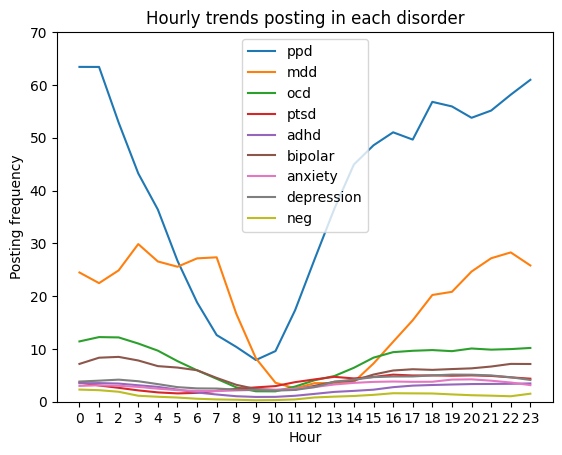

In [169]:
for i in range(hourly_rate.shape[0]):
    plt.plot(hourly_rate[i], label=f'{LABEL[i]}')

# Set the plot title and labels
plt.title('Hourly trends posting in each disorder')
plt.ylim(0, 70)
plt.xticks(range(24))
plt.xlabel('Hour')
plt.ylabel('Posting frequency')

# Show the legend
plt.legend()

# Show the plot
plt.show()